Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [1]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
#%matplotlib qt 
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

## Folder dir for saving and loading files

In [2]:
# model_name ='test'
# model_name = 'mtm_3links'
# model_name = 'mtm'
# model_name = 'mtm_spring'
#model_name = 'mtm_2spring'
#model_name = 'mtm_2spring_tendon'
# model_name = 'mtm_4links_parallel'
# model_name = 'mtm_3links_parallel'

model_name = 'psm_simple'
#model_name = 'psm_complete'


model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')
_pi = sympy.pi

dh = []
springs = []
friction_type = []
tendon_couplings = []


if model_name =='test':
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, False),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, False)]
    q = q1
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s]
    friction_type = ['Coulomb', 'viscous', 'offset']
elif model_name == 'mtm':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    #springs = [tau_s]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    print("MTM")
elif model_name == 'mtm_spring':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
elif model_name == 'mtm_2spring':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s, -q4]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
elif model_name == 'mtm_2spring_tendon':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s, -q4]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    tendon_couplings = [(4, 3, 2.0/3.0)] # tau_3 += 2/3*tau_4
    print(model_name)
elif model_name == 'mtm_3links_parallel':
    # define paralelogram coordinate relation
    q3 = -q2 + q4
    q5 = -q4 + q2
    q6 = q4 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,4],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.2794, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   1,  [5],    0,     -_pi/2, 0,        q4+_pi,   True,  False, True),
          (5,   4,  [6],   0.1,   0,      0,        q5-_pi/2, True,  False, True),
          (6,   5,  [],     0.2794, 0,      0,        q6,      False, False, True)]
    friction_type = ['Coulomb', 'viscous', 'offset']
    #springs = [q1, q2, q3]
elif model_name == 'mtm_4links_parallel':
    # define paralelogram coordinate relation
    q3 = -q2 + q5
    q6 = -q5 + q2
    q7 = q5 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,5],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [0],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   1,  [6],     0,     -_pi/2, 0,        q5+_pi,   True,  False, True),
          (6,   5,  [7],   0.1,   0,      0,        q6-_pi/2, True,  False, True),
          (7,   6,  [],     0.279, 0,      0,        q7,      False, False, True)]
    friction_type = ['Coulomb', 'viscous']
elif model_name == 'mtm_3links':
    dh = [(0,   -1, [1],    0,      0,      0,          0,         False, False, False),
          (1,   0,  [2],    0,      0,      -0.21537,   q1,        True,  False, True),
          (2,   1,  [3],    0,      -_pi/2, 0,          q2+_pi/2,  True,  False, True),
          (3,   2,  [4],    0.279,  0,      0,          q3+_pi/2,  True,  True,  True)]
    # springs = [q1]
    friction_type = ['Coulomb', 'viscous']
elif (model_name == 'psm_simple'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    x = [None]*12
    x[0]  = ( 0,  -1,  [1],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [4, 7], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back                                  )
    x[4]  = ( 4,   3,  [5],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[5]  = ( 5,   4,  [6],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[6]  = ( 6,   5, [9],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[7]  = ( 7,   3, [8],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[8]  = ( 8,  7,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    x[9] = (9,   6, [10],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[10] = (10,  9, [11],          0, -sympy.pi/2,     0,          -sympy.pi/2+q5, False,  True,  True) # Tool Pitch
    x[11] = (11,  10, [12,13],  0.0091, -sympy.pi/2,     0,          -sympy.pi/2+q6, False,  True,  True) # Tool Yaw
    #x[12] = (12,  11, [],            0,           0,     0,                     -q7, False, False,  True) # Gripper1
    #x[13] = (13,  11, [],            0,           0,     0,                      q7, False,  True,  True) # Gripper2
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
    
elif (model_name == 'psm_complete'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    x = [None]*15
    x[0]  = ( 0,  -1,  [1],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3, 4, 5],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [6, 10], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back
    x[4]  = ( 4,   2,  [] ,     0.0664,           0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Front                                    )
    x[5]  = ( 5,   2,  [7],    -0.0296,           0,     0,   q2-beta2 - sympy.pi/2, False, False, False)    # Intermediate
    x[6]  = ( 6,   3,  [8],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[7]  = ( 7,   5,   [],     0.1842,           0,     0,    -q2+beta2+sympy.pi/2,  True, False,  True)    # Pitch Top
    x[8]  = ( 8,   6,  [9],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[9]  = ( 9,   8, [12],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[10] = (10,   3, [11],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[11] = (11,  10,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    
    x[12] = (12,   9, [13],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[13] = (13,  12, [14],          0, -sympy.pi/2,     0,          -sympy.pi/2+q5, False,  True,  True) # Tool Pitch
    x[14] = (14,  13, [15,16],  0.0091, -sympy.pi/2,     0,          -sympy.pi/2+q6, False,  True,  True) # Tool Yaw
    #x[15] = (15,  14, [],            0,           0,     0,                     -q7, False, False,  True) # Gripper1
    #x[16] = (16,  15, [],            0,           0,     0,                      q7, False,  True,  True) # Gripper2
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
else:
    raise Exception("No robot name matches " + name)
print(friction_type)
robot_def = RobotDef(dh,
                     springs=springs,
                     tendon_couplings=tendon_couplings,
                     dh_convention='mdh',
                     friction_type=friction_type)

psm_simple
['Coulomb', 'viscous', 'offset']


In [4]:
robot_def.dq_for_frame

In [5]:
robot_def.coordinates_joint_type

['R', 'R', 'P', 'R', 'R', 'R']

In [6]:
robot_def.bary_params

In [7]:
robot_def.K

## Create kinematics chain

In [8]:
%time geom = Geometry(robot_def)

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
CPU times: user 5min 41s, sys: 1.66 s, total: 5min 42s
Wall time: 5min 41s


In [9]:
angle = [0, 0, 0, 0, 0, 0, 0]
geom.draw_geom(angle)

## Create dynamics

In [10]:
dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/11
Calculating the link kinetic energy of 3/11
Calculating the link kinetic energy of 4/11
Calculating the link kinetic energy of 5/11
Calculating the link kinetic energy of 6/11
Calculating the link kinetic energy of 8/11
Calculating joint torques...
tau of q1
tau of q2
tau of q3
tau of q4
tau of q5
tau of q6
Adding frictions and springs...
Add tendon coupling torque and motor inertia...
Calculating gregressor...
('input_vars', (q1, q2, q3, q4, q5, q6, dq1, dq2, dq3, dq4, dq5, dq6, ddq1, ddq2, ddq3, ddq4, ddq5, ddq6))
Calculating M, C and G...
Calculating base parameter...
[61 60 59 74 73 71 58 72 33 14 17 15 40 87 89 79 26 81 85 63 83 44 24 11
 88 80 84 12 38 64  6 36 82 78 62 10 86 46 45 21 13 19 20 43 47 16 41 39
 56 52 57 50 51  5 77 76 48 75 49 54  7 34 53 65 37 66 68 35 25 42 23 67
 69 55 18 70  4  2  8 30 29  0 32  1 28  3 31 27 22  9]
base parameter number: 37
Creating H_b function...
Finished creating robot dy

In [11]:
robot_def.bary_params

In [12]:
sympy.Matrix(dyn.base_param)

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [14]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Saved {} parameters'.format(len(robot_model.base_param)))

Saved 37 parameters


In [15]:
for tendon_coupling in dyn.rbt_def.tendon_couplings:
    src_frame, dst_frame, k = tendon_coupling
    dq_src = dyn.rbt_def.dq_for_frame[src_frame]
    dq_dst = dyn.rbt_def.dq_for_frame[dst_frame]
    src_index = dyn.rbt_def.d_coordinates.index(dq_src)

    for a in range(len(dyn.rbt_def.d_coordinates)):
        dq_da = sympy.diff(dq_dst, dyn.rbt_def.d_coordinates[a])
        #tau_c[a] += dq_da * k * tau_csf[src_index]
        print(a, dq_da, k)
dyn.rbt_def.tendon_couplings 
2/3

---
# 3 - Excitation trajectory optimization

In [4]:
# model_name = 'test_psm_long2'
# model_name ='test'
# model_name = 'mtm_3links'
# model_name = 'mtm'
#model_name = 'mtm_spring'
# model_name = 'mtm_2spring'
#model_name = 'mtm_2spring_tendon'
#model_name = 'mtm_3links_parallel'
# model_name = 'mtm_4links_parallel'

#model_name = 'psm_no_off_minert'
model_name = 'psm_simple'
#model_name = 'psm_complete'

Load Data

In [5]:
from utils import load_data
model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [6]:
trajectory_name = 'six'
#trajectory_name = 'two'
# trajectory_name = 'two_normalized'

In [ ]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'

base_freq = 0.2
fourier_order = 6

joint_constraints = []
cartesian_constraints = []

if model_name == 'mtm' or model_name == 'mtm_spring'\
    or model_name == 'mtm_2spring' or model_name == 'mtm_2spring_tendon':
    joint_constraints = [(q1, deg2rad(-57), deg2rad(29), deg2rad(-160), deg2rad(160)),
                         (q2, deg2rad(-10), deg2rad(60), deg2rad(-180), deg2rad(180)),
                         (q3, deg2rad(-30), deg2rad(30), deg2rad(-180), deg2rad(180)),
                         (q4, deg2rad(-40), deg2rad(195), -6*np.pi, 6*np.pi),
                         (q5, deg2rad(-87), deg2rad(180), -6*np.pi, 6*np.pi),
                         (q6, deg2rad(-40), deg2rad(38), -6*np.pi, 6*np.pi),
                         (q7, deg2rad(-460), deg2rad(450), -10*np.pi, 10*np.pi),
                         (q8, deg2rad(-9), deg2rad(39), deg2rad(-150), deg2rad(150))]

#     cartesian_constraints = [(3,'max',1,0.4,1),
#                              (3,'min',-1,-1,-1)]
elif model_name == 'mtm_3links':
    joint_constraints = [(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                         (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                         (q3, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)]
    
    cartesian_constraints = [(1,'max',1,0.4,1),
                             (1,'min',-1,-1,-1),
                             (2,'max',1,0.4,1),
                             (2,'min',-1,-1,-1)]
    
    # MTM STUFF
#jnt_cnst = [(q1, -0.698132, 1.13446, -2, 2),(q2, -0.261799, 0.872665, -2, 2), (q3,-0.172665, 0.610865, -2, 2)]
#jnt_cnst = [(q1, -1.5, 1.5, -2, 2),(q2, -1.5, 1.5, -2, 2), (q3,-1.5, 1.5, -2, 2)]    

#crt_cnst = [(4, 'max', -0.283, 0.279, -0.25137), (4, 'min', -0.5, -0.321, -0.39137)]
#crt_cnst = [(3, 'max', -0.300, 0.3, -0.26137), (3, 'min', -0.5, -0.45, -0.53137)]
elif model_name == 'mtm_3links_parallel' or model_name == 'mtm_3links_parallel_offset':
    joint_constraints = [(q1, deg2rad(-57), deg2rad(29), deg2rad(-160), deg2rad(160)),
                         (q2, deg2rad(-10), deg2rad(60), deg2rad(-180), deg2rad(180)),
                         (q3, deg2rad(-30), deg2rad(30), deg2rad(-180), deg2rad(180)),
                         (q4, deg2rad(-9), deg2rad(39), deg2rad(-360), deg2rad(360))]
elif model_name == 'mtm_4links_parallel':
    joint_constraints = [(q1, deg2rad(-60), deg2rad(32), deg2rad(-180), deg2rad(180)),
                         (q2, deg2rad(-12), deg2rad(62), deg2rad(-180), deg2rad(180)),
                         (q3, deg2rad(-32), deg2rad(32), deg2rad(-180), deg2rad(180)),
                         (q4, deg2rad(-90), deg2rad(195), -2*np.pi, 2*np.pi),
                         (q5, deg2rad(-9), deg2rad(39), deg2rad(-360), deg2rad(360))]
elif model_name == 'psm':
    pass
elif model_name == 'psm_simple':
    joint_constraints = [(q1, -1.45, 1.45, -2, 2),
                         (q2, -0.75, 0.8, -2, 2),
                         (q3,0.05,0.235,-0.4,0.4),
                         (q4,-1.5,1.5,-2,2),
                             (q5,-1.5,1.5,-3,3), 
                         (q6,-1.5,1.5,-3,3)]
                         #(q7,0.05, 0.75,-0.4,0.4)]
else:
    raise Exception("No robot name matches " + model_name)
    
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 6
cartesian constraint number: 0
constraint number: 24
frames_constrained: []
cond: 118.493129485
cond: 118.493151792
cond: 118.493147385
cond: 118.493128796
cond: 118.493128895
cond: 118.493134663
cond: 118.493137853
cond: 118.493137412
cond: 118.49314936
cond: 118.493146838
cond: 118.493139974
cond: 118.493137332
cond: 118.493137309
cond: 118.493131152
cond: 118.493053565
cond: 118.493103404
cond: 118.493119238
cond: 118.493130109
cond: 118.493133168
cond: 118.493129707
cond: 118.493129507
cond: 118.493196664
cond: 118.493163665
cond: 118.493157579
cond: 118.493149105
cond: 118.493143701
cond: 118.493143896
cond: 118.493083255
cond: 118.49313117
cond: 118.493132541
cond: 118.493131253
cond: 118.493129535
cond: 118.493128622
cond: 118.493128849
cond: 118.493161509
cond: 118.493142765
cond: 118.493138596
cond: 118.493137529
cond: 118.493134925
cond: 118.493134153
cond: 118.493129485
cond: 118.493129485
cond: 118.493129485
cond: 118.493129485
cond: 118.493129485

cond: 98.2615678374
cond: 98.2615923097
cond: 98.2615796473
cond: 98.261571917
cond: 98.2615741975
cond: 98.261556328
cond: 98.2615400996
cond: 98.2617164331
cond: 98.2614581119
cond: 98.2615000117
cond: 98.2615198083
cond: 98.2615308551
cond: 98.2615535265
cond: 98.2615723775
cond: 98.2614457023
cond: 98.2615154863
cond: 98.2615585607
cond: 98.2615773159
cond: 98.2615754199
cond: 98.2615808745
cond: 98.2615715053
cond: 98.2615728403
cond: 98.2615704546
cond: 98.2615698305
cond: 98.2615690312
cond: 98.2615672068
cond: 98.2615692296
cond: 98.261567183
cond: 98.2615683222
cond: 98.2615672961
cond: 98.2615674405
cond: 98.2615670178
cond: 98.261568687
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond: 98.2615694887
cond

cond: 195.103029012
cond: 195.102724226
cond: 195.102914354
cond: 195.103032685
cond: 195.103054243
cond: 195.103043659
cond: 195.103045303
cond: 195.103019608
cond: 195.10299445
cond: 195.103021162
cond: 195.103028147
cond: 195.103014689
cond: 195.103006901
cond: 195.103019463
cond: 195.10300157
cond: 195.102992048
cond: 195.103012395
cond: 195.103010325
cond: 195.102997917
cond: 195.102998633
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
cond: 195.103021619
co

cond: 206.454742657
cond: 206.454824683
cond: 206.454448303
cond: 206.45467998
cond: 206.454803692
cond: 206.454829293
cond: 206.454817104
cond: 206.454817648
cond: 206.454792303
cond: 206.454780409
cond: 206.454800098
cond: 206.454803831
cond: 206.454794956
cond: 206.454789909
cond: 206.454801269
cond: 206.454784326
cond: 206.454785218
cond: 206.454794007
cond: 206.454791462
cond: 206.454781806
cond: 206.454776356
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
cond: 206.454803339
c

cond: 206.440601321
cond: 206.440601801
cond: 206.440635482
cond: 206.440641789
cond: 206.440604752
cond: 206.441054428
cond: 206.440256392
cond: 206.440385844
cond: 206.440474276
cond: 206.44051081
cond: 206.440570892
cond: 206.440652863
cond: 206.440276372
cond: 206.440508164
cond: 206.440631868
cond: 206.440657458
cond: 206.440645279
cond: 206.440645784
cond: 206.440620466
cond: 206.440608577
cond: 206.440628249
cond: 206.440631981
cond: 206.440623123
cond: 206.440618063
cond: 206.440629427
cond: 206.440612481
cond: 206.44061335
cond: 206.440622159
cond: 206.440619593
cond: 206.440609944
cond: 206.440604523
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
cond: 206.440631489
co

cond: 206.438418335
cond: 206.438418335
cond: 206.438418335
cond: 206.438418335
cond: 206.438418335
cond: 206.438418335
cond: 206.438418335
cond: 426.547057248
cond: 253.720406595
cond: 215.587060735
cond: 209.923660135
cond: 209.239170901
cond: 208.366019755
cond: 208.603195058
cond: 208.642977594
cond: 206.437944851
cond: 206.437934317
cond: 206.437938265
cond: 206.43792073
cond: 206.437914809
cond: 206.438001004
cond: 206.437945158
cond: 206.437960936
cond: 206.438043094
cond: 206.437914725
cond: 206.437915156
cond: 206.437948854
cond: 206.437955158
cond: 206.437918126
cond: 206.438367796
cond: 206.437569744
cond: 206.437699208
cond: 206.437787641
cond: 206.43782418
cond: 206.43788426
cond: 206.437966221
cond: 206.437589741
cond: 206.437821525
cond: 206.437945233
cond: 206.437970826
cond: 206.437958645
cond: 206.437959149
cond: 206.43793383
cond: 206.437921931
cond: 206.437941611
cond: 206.437945345
cond: 206.437936485
cond: 206.437931423
cond: 206.43794279
cond: 206.437925839
cond:

cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 206.436601825
cond: 425.252370134
cond: 252.532987125
cond: 215.501231684
cond: 209.887295771
cond: 209.254265836
cond: 208.372861996
cond: 208.604072026
cond: 208.641579697
cond: 208.645320919
cond: 206.436557184
cond: 206.436546647
cond: 206.436550586
cond: 206.43653305
cond: 206.436527137
cond: 206.436613331
cond: 206.436557489
cond: 206.436573271
cond: 206.436655366
cond: 206.436527088
c

cond: 206.436503756
cond: 206.43652935
cond: 206.436517168
cond: 206.436517671
cond: 206.436492351
cond: 206.43648045
cond: 206.436500131
cond: 206.436503866
cond: 206.436495006
cond: 206.436489942
cond: 206.43650131
cond: 206.43648436
cond: 206.436485219
cond: 206.43649404
cond: 206.436491472
cond: 206.436481819
cond: 206.4364764
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 206.436503371
cond: 2

cond: 339.0598964
cond: 339.059896769
cond: 339.05989295
cond: 339.059897831
cond: 339.059880214
cond: 339.059893041
cond: 339.059896682
cond: 339.059898975
cond: 339.059893554
cond: 339.059902615
cond: 339.059906893
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
cond: 339.059898583
con

cond: 272.375570418
cond: 272.375570211
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 272.37556568
cond: 338.276785658
cond: 267.982321774
cond: 267.982388055
cond: 267.982340664
cond: 267.982382356
cond: 267.98238275
cond: 267.982380869
cond: 267.982263809


In [ ]:
reg_norm_mat = traj_optimizer.calc_normalize_mat()

## Plot optimal excitation trajectory

In [ ]:
traj_optimizer.calc_frame_traj()

In [ ]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind, robot_model.coordinates)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [ ]:
dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, reg_norm_mat)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

freq = 500
tf = 35 # including 5 seconds' prestable time
traj_optimizer.make_traj_csv(trajectory_folder, trajectory_name, freq, tf)

In [ ]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

---
# Data processing

In [5]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

### Load robot model

In [97]:
# Names as Arguments
# model_name = 'test_psm_long'
# model_name = 'mtm_3links'
# model_name = 'mtm'
# model_name = 'mtm_spring'
#model_name = 'mtm_2spring_tendon'

#model_name == 'mtm_3links_parallel'
# model_name == 'mtm_4links_parallel'

#model_name = 'psm_no_off_minert'
model_name = 'psm_complete'


training_trajectory_name = 'five'


model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,model_name)


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                          training_trajectory_name)
#dof, fourier_order, base_freq, traj_optimizer_result = load_data(trajectory_folder,training_trajectory_name)
     
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 6
Fourier order: 6
Base frequency: 0.18


In [98]:
robot_model.coordinates

### Load traning data set

In [99]:
# training_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

# Reverse the process to get the original effort for each motor for the MTM
if 'mtm' in model_name:
    tau_raw_train[:,1] = tau_raw_train[:,1] - tau_raw_train[:,2] + 0.5515/0.8235 * tau_raw_train[:, 3]
    tau_raw_train[:,2] = tau_raw_train[:,2] - 0.5515/0.8235 * tau_raw_train[:, 3]

(<type 'numpy.ndarray'>, (14989, 18))


### Load test data set

In [100]:
test_trajectory_name = 'four'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                trajectory_sampling_rate)

# Reverse the process to get the original effort for each motor for the MTM
if 'mtm' in model_name:
    tau_raw_test[:,1] = tau_raw_test[:,1] - tau_raw_test[:,2] + 0.5515/0.8235 * tau_raw_test[:, 3]
    tau_raw_test[:,2] = tau_raw_test[:,2] - 0.5515/0.8235 * tau_raw_test[:, 3]

(<type 'numpy.ndarray'>, (14989, 18))


## Calculate filter cut-off frequency

In [108]:
# times of the highest frequency in the Fourier series
#fc_mult = 4.0

#fc_mult = [1.3] #(good)
fc_mult = [1.1, 1.1, 1.1, 3,3, 3]

#fc_mult = 4
print(base_freq)
fc = np.array(fc_mult)*base_freq* fourier_order 

print(fc)
fc.shape[0] == 1
#print("Cut frequency: {}".format(fc))

0.18
[1.188 1.188 1.188 3.24  3.24  3.24 ]


False

## Differentiation and filtering

### Traning data

[0.01492885 0.01492885 0.01492885 0.04071504 0.04071504 0.04071504]
q_raw shape: (14989, 6)
plot shape: 460


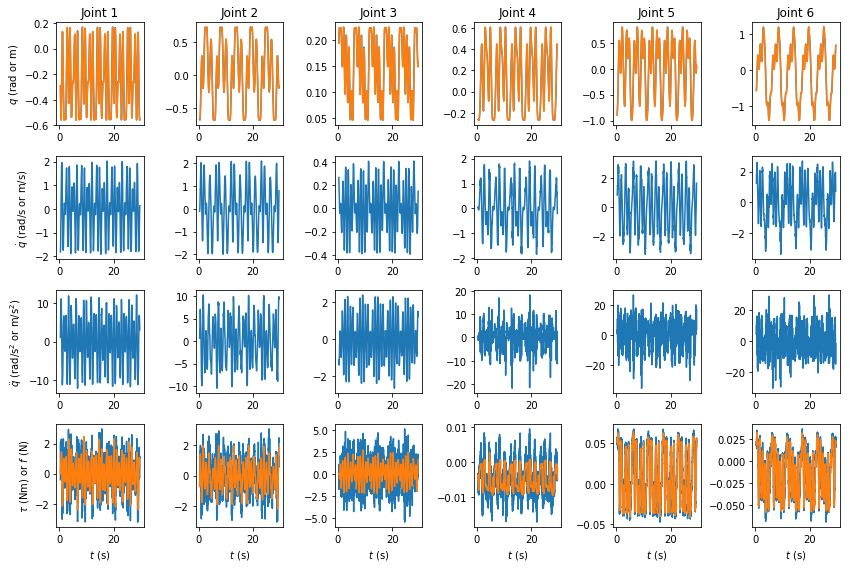

In [109]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

### Test data

[0.01492885 0.01492885 0.01492885 0.04071504 0.04071504 0.04071504]
q_raw shape: (14989, 6)
plot shape: 460


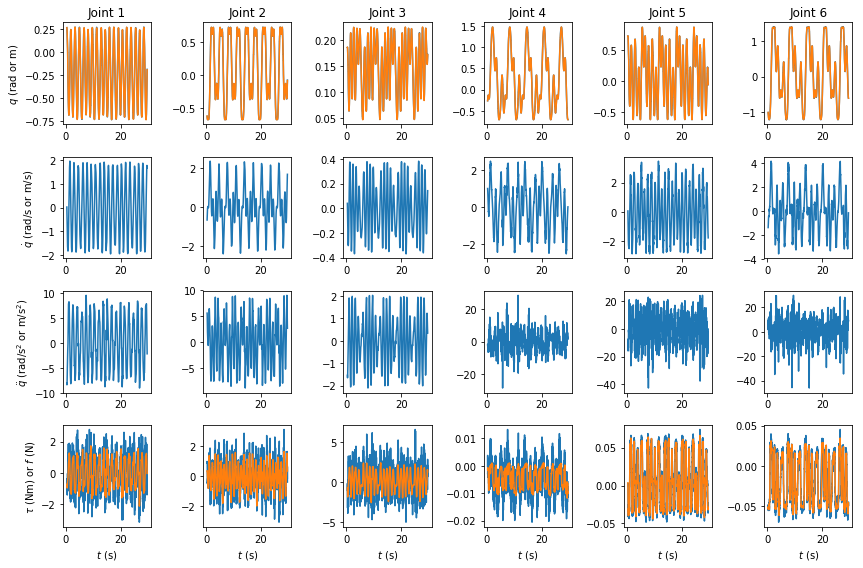

In [110]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [111]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [112]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [113]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

/home/radian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [114]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 50
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Base Parameter,Value
1.0*m9,0.4223137543747591
-0.36018965*l3x - 0.10779909*l3y - 0.36018965*l4x ...,0.062053613548842174
0.10779909*l3x - 0.36018965*l3y + 0.10779909*l4x -...,-0.022641680102692092
1.0*m11,0.6649781043762152
-0.37597504*l1y - 0.37597504*l3z - 0.37597504*l4z ...,0.02981423768562329
1.0*l11z + 0.59782515*l3x + 0.17891964*l3y + 0.597...,-0.15593542721750034
1.0*l11x - 0.17891964*l3x + 0.59782515*l3y - 0.178...,0.0767609294122381
1.0*l11y + 0.62402496*l1y + 0.62402496*l3z + 0.624...,-0.05211798967507453
1.0*l7y,0.37371145673836004
-0.27468079*L11xx + 1.0*L3xy + 1.0*L4xy - 0.274680...,0.005805171225836386


## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [115]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [116]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.00035983216284093283
standard deviation of xb using OLS:
[1.17562915e-04 5.72777314e-05 5.82252973e-05 2.82722544e-04
 3.15375869e-04 7.35281320e-05 1.00387963e-04 5.26635655e-04
 4.27141291e-02 6.52332601e-04 1.30237108e-04 5.63042338e-05
 2.01051046e-03 2.41871364e-04 3.16329872e-05 3.06003500e-04
 1.87107195e-03 2.07383659e-04 1.89908610e-04 1.72765535e-05
 7.02178373e-05 1.84158228e-05 2.70394619e-04 4.05063051e-03
 2.26162631e-02 1.57126073e-04 1.57080838e-04 1.58304066e-04
 1.18764275e-03 8.29718195e-03 1.82963283e-03 2.90623621e-04
 2.92704559e-04 3.12462948e-04 2.73015102e-04 2.80469566e-04
 2.84626022e-04 6.49717406e-02]
percentage of standard deviation of xb using OLS: 
[2.78378134e-04 9.23036197e-04 2.57159791e-03 4.25160682e-04
 1.05780289e-02 4.71529359e-04 1.30780025e-03 1.01046809e-02
 1.14297082e-01 1.12370949e-01 9.70196167e-03 9.50392414e-03
 4.99497916e-01 2.16870509e-03 2.97294010e-01 2.33619510e-01
 1.35093738e-03 1.9427867

### Plot measured torque and predicted torque

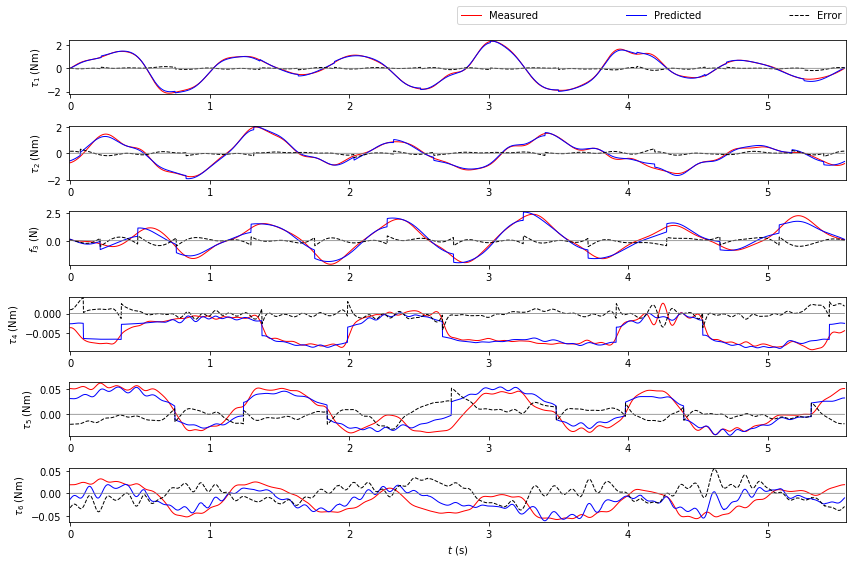

In [117]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on the test set

In [118]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

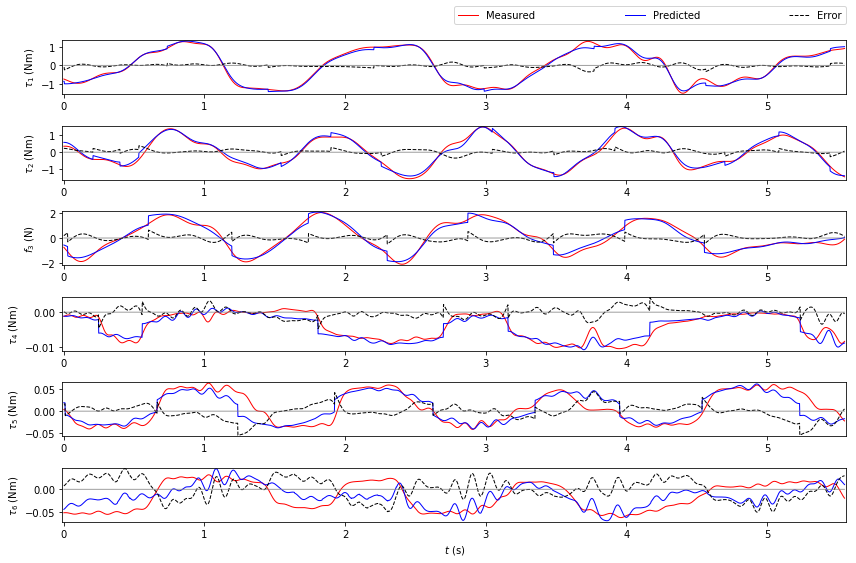

In [119]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [120]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_test[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.10076372, 0.14187349, 0.17515036, 0.23866088, 0.46461956,
       0.65690515])

## Weighted Least Square (WLS)

### Training data set

In [260]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
weight

array([4.62192453, 6.22053063, 7.37273534, 0.01912755, 0.12081109,
       0.09958247])

In [261]:
W_b_train.shape, tau_s_train.shape

In [193]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [194]:
weights.shape

In [195]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [196]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

/home/radian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [197]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [198]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

In [199]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type, 
                   robot_model.coordinates)

In [200]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.09146403, 0.07401256, 0.0940422 , 0.22587164, 0.50210069,
       0.32138683])

In [201]:
robot_model.bary_param

In [202]:
robot_def.d_coordinates[0] != robot_def.dq_for_frame[1]

False

In [203]:
robot_model.coordinates[1].name[1:]

'2'

### Test data set

In [206]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
weight
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [207]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.15105141, 0.12167208, 0.10345905, 0.28276485, 0.41061362,
       0.78134663])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [40]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [41]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

In [42]:
len(robot_model.std_param)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [43]:
sdp_constraints = []
spring_constraints = []
if model_name == 'mtm' or model_name == 'mtm_2spring_tendon':
    sdp_constraints = [(2, 20, -0.1, 0.1, -0.1, 0.1, -0.1, 0.3, 0.2, 0.2, 0.2),
                      (1, 10, -0.1, 0.2, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2),
                      (1, 10, -0.0, 0.3, -0.02, 0.02, -0.01, 0.01, 0.2, 0.2, 0.2),
                      (0.2, 5, -0.01, 0.01, -0.0, 0.1, -0.1, 0.0, 0.2, 0.2, 0.1),
                      (0.1, 2, -0.01, 0.01, -0.05, 0.0, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.05, 0.5, -0.005, 0.005, -0.00, 0.05, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.05, 0.5, -0.000, 0.000, -0.00, 0.00, -0.00, 0.05, 0.1, 0.1, 0.1),
                      (1, 10, -0.10, 0.05, -0.05, 0.05, -0.05, 0.05, 0.1, 0.2, 0.2),
                      (0.05, 0.5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1),
                      (0.0, 0, 0.00, 0.00, -0.00, 0.00, 0.000, 0.00, 0.1, 0.1, 0.0)]
    spring_constraints = [(250, 300), (0.001, 0.1)]
elif model_name == 'mtm_3links':
    sdp_constraints = [(0.5, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.3, 0.5, 0.5, 0.5),
                      (0.3, 5, -0.1, 0.2, -0.05, 0.05, -0.05, 0.05, 0.5, 0.5, 0.5),
                      (0.1, 3, -0.0, 0.3, -0.02, 0.02, -0.01, 0.01, 0.1, 0.5, 0.5),
                      (0.1, 1, -0.01, 0.01, -0.0, 0.1, -0.1, 0.0, 0.1, 0.1, 0.1),
                      (0.02, 0.3, -0.01, 0.01, -0.05, 0.0, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.02, 0.2, -0.005, 0.005, -0.00, 0.05, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.01, 0.1, -0.000, 0.000, -0.00, 0.00, -0.00, 0.05, 0.1, 0.1, 0.1),
                      (0.3, 5, -0.10, 0.05, -0.05, 0.05, -0.05, 0.05, 0.5, 0.5, 0.5),
                      (0.3, 5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1),
                      (0.3, 5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1)]
else:
    raise Exception("No robot name matches " + model_name)

In [57]:


sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model,
                     sdp_constraints, spring_constraints)
# sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints)
%time sdp_opt_std.solve()

Regressor shape: (102123, 122)
Regressand shape: (102123,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 4727149, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
Variables n = 123, constraints m = 102451
Cones:	linear vars: 137
	soc vars: 102125, soc blks: 1
	sd vars: 189, sd blks: 9
Setup time: 1.93e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.39e+01  9.74e-01  1.00e+00 -1.02e+04 -2.26e-03  5.06e-12  2.32

  9400| 8.11e-02  2.56e-05  2.82e-04  4.45e-01  4.45e-01  2.11e-12  5.98e+02 
  9500| 8.11e-02  1.20e-05  2.86e-04  4.49e-01  4.50e-01  4.21e-13  6.04e+02 
  9600| 8.11e-02  4.14e-05  2.89e-04  4.54e-01  4.55e-01  2.11e-12  6.10e+02 
  9700| 8.11e-02  6.02e-05  2.95e-04  4.59e-01  4.59e-01  2.11e-12  6.15e+02 
  9800| 8.10e-02  7.32e-05  3.01e-04  4.63e-01  4.64e-01  4.21e-13  6.20e+02 
  9900| 8.10e-02  7.41e-05  3.06e-04  4.68e-01  4.69e-01  4.21e-13  6.26e+02 
 10000| 8.11e-02  6.43e-05  3.09e-04  4.73e-01  4.73e-01  1.26e-12  6.31e+02 
 10100| 8.11e-02  4.79e-05  3.13e-04  4.77e-01  4.78e-01  2.95e-12  6.37e+02 
 10200| 8.11e-02  2.24e-05  3.18e-04  4.82e-01  4.83e-01  2.11e-12  6.42e+02 
 10300| 8.11e-02  1.49e-05  3.23e-04  4.87e-01  4.88e-01  4.21e-13  6.47e+02 
 10400| 8.11e-02  3.03e-05  3.28e-04  4.92e-01  4.92e-01  1.26e-12  6.53e+02 
 10500| 8.11e-02  4.94e-05  3.31e-04  4.96e-01  4.97e-01  2.95e-12  6.58e+02 
 10600| 8.10e-02  6.10e-05  3.35e-04  5.01e-01  5.02e-01  1.26e-

 20000| 8.10e-02  3.00e-06  6.10e-04  9.43e-01  9.45e-01  4.21e-13  1.13e+03 
 20100| 8.10e-02  7.14e-06  6.12e-04  9.48e-01  9.49e-01  4.21e-13  1.14e+03 
 20200| 8.10e-02  5.26e-06  6.14e-04  9.52e-01  9.54e-01  2.95e-12  1.14e+03 
 20300| 8.10e-02  8.82e-06  6.16e-04  9.57e-01  9.59e-01  4.21e-13  1.15e+03 
 20400| 8.10e-02  9.51e-06  6.18e-04  9.62e-01  9.64e-01  4.21e-13  1.15e+03 
 20500| 8.10e-02  8.59e-06  6.20e-04  9.66e-01  9.68e-01  4.21e-13  1.16e+03 
 20600| 8.10e-02  9.54e-06  6.22e-04  9.71e-01  9.73e-01  4.21e-13  1.16e+03 
 20700| 8.10e-02  5.09e-06  6.24e-04  9.76e-01  9.78e-01  4.21e-13  1.17e+03 
 20800| 8.10e-02  6.79e-06  6.26e-04  9.81e-01  9.82e-01  4.21e-13  1.17e+03 
 20900| 8.10e-02  3.99e-06  6.28e-04  9.85e-01  9.87e-01  1.26e-12  1.18e+03 
 21000| 8.10e-02  5.73e-06  6.29e-04  9.90e-01  9.92e-01  2.95e-12  1.18e+03 
 21100| 8.10e-02  7.98e-06  6.31e-04  9.95e-01  9.97e-01  1.26e-12  1.18e+03 
 21200| 8.10e-02  6.89e-06  6.33e-04  9.99e-01  1.00e+00  1.26e-

 30600| 8.09e-02  4.20e-06  7.56e-04  1.44e+00  1.44e+00  1.27e-12  1.66e+03 
 30700| 8.09e-02  2.63e-06  7.57e-04  1.45e+00  1.45e+00  2.11e-12  1.67e+03 
 30800| 8.09e-02  3.41e-06  7.58e-04  1.45e+00  1.45e+00  1.27e-12  1.67e+03 
 30900| 8.09e-02  3.81e-06  7.59e-04  1.45e+00  1.46e+00  4.22e-13  1.68e+03 
 31000| 8.09e-02  2.39e-06  7.59e-04  1.46e+00  1.46e+00  1.27e-12  1.68e+03 
 31100| 8.09e-02  4.30e-06  7.60e-04  1.46e+00  1.47e+00  1.27e-12  1.68e+03 
 31200| 8.09e-02  2.18e-06  7.61e-04  1.47e+00  1.47e+00  1.27e-12  1.69e+03 
 31300| 8.09e-02  3.89e-06  7.62e-04  1.47e+00  1.48e+00  2.95e-12  1.69e+03 
 31400| 8.09e-02  3.12e-06  7.63e-04  1.48e+00  1.48e+00  4.22e-13  1.70e+03 
 31500| 8.09e-02  2.84e-06  7.64e-04  1.48e+00  1.49e+00  2.11e-12  1.70e+03 
 31600| 8.09e-02  3.98e-06  7.65e-04  1.49e+00  1.49e+00  4.22e-13  1.71e+03 
 31700| 8.09e-02  2.07e-06  7.66e-04  1.49e+00  1.50e+00  2.11e-12  1.71e+03 
 31800| 8.09e-02  4.15e-06  7.67e-04  1.50e+00  1.50e+00  4.22e-

 41200| 8.08e-02  2.98e-06  8.35e-04  1.94e+00  1.94e+00  2.96e-12  2.15e+03 
 41300| 8.08e-02  3.01e-06  8.35e-04  1.94e+00  1.95e+00  4.22e-13  2.15e+03 
 41400| 8.08e-02  3.36e-06  8.36e-04  1.95e+00  1.95e+00  1.27e-12  2.16e+03 
 41500| 8.08e-02  2.70e-06  8.36e-04  1.95e+00  1.96e+00  1.27e-12  2.16e+03 
 41600| 8.08e-02  3.46e-06  8.37e-04  1.96e+00  1.96e+00  1.27e-12  2.17e+03 
 41700| 8.08e-02  2.79e-06  8.37e-04  1.96e+00  1.96e+00  4.22e-13  2.17e+03 
 41800| 8.08e-02  3.24e-06  8.38e-04  1.97e+00  1.97e+00  1.27e-12  2.17e+03 
 41900| 8.08e-02  3.16e-06  8.38e-04  1.97e+00  1.97e+00  4.22e-13  2.18e+03 
 42000| 8.08e-02  2.87e-06  8.39e-04  1.97e+00  1.98e+00  1.27e-12  2.18e+03 
 42100| 8.08e-02  3.43e-06  8.39e-04  1.98e+00  1.98e+00  4.22e-13  2.19e+03 
 42200| 8.08e-02  2.72e-06  8.40e-04  1.98e+00  1.99e+00  4.22e-13  2.19e+03 
 42300| 8.08e-02  3.39e-06  8.40e-04  1.99e+00  1.99e+00  1.27e-12  2.20e+03 
 42400| 8.08e-02  2.96e-06  8.41e-04  1.99e+00  2.00e+00  4.22e-

## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [58]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [59]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_sdp_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.07897814, 0.31287993, 0.17930951, 0.26768465, 0.29612818,
       0.2220772 , 0.26818115])

### Plot measured torque and predicted torque

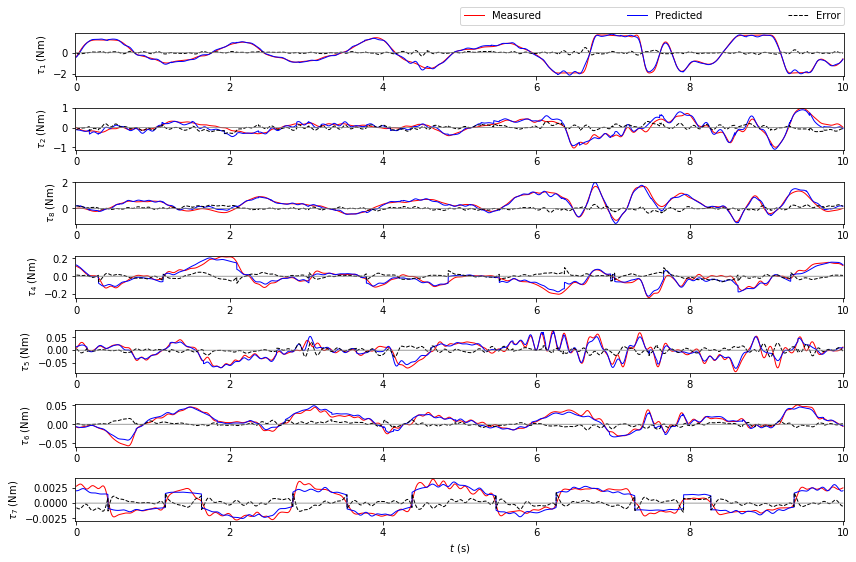

In [73]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on test set

In [61]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

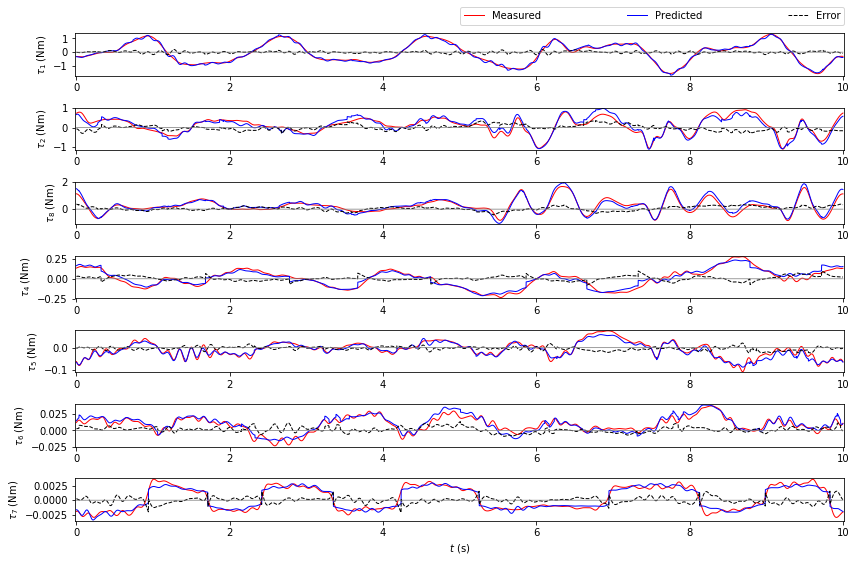

In [74]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [63]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.09879577, 0.32548518, 0.28563868, 0.25714807, 0.25187338,
       0.29823386, 0.24384046])

In [64]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx     2.6343054888674   ⎤
⎢                           ⎥
⎢L1xy  -4.46223463925424e-14⎥
⎢                           ⎥
⎢L1xz  9.56844769208569e-24 ⎥
⎢                           ⎥
⎢L1yy    2.63430548886742   ⎥
⎢                           ⎥
⎢L1yz  1.11467480731081e-17 ⎥
⎢                           ⎥
⎢L1zz   8.48601005291674e-6 ⎥
⎢                           ⎥
⎢l1x   5.85046325777972e-23 ⎥
⎢                           ⎥
⎢l1y   -1.89889430298544e-17⎥
⎢                           ⎥
⎢l1z     0.515973583715752  ⎥
⎢                           ⎥
⎢ m₁     3.82378587565491   ⎥
⎢                           ⎥
⎢Fc₁    0.0319006663095601  ⎥
⎢                           ⎥
⎢Fv₁    0.0552209852590067  ⎥
⎢                           ⎥
⎢Fo₁    -0.0608126942836563 ⎥
⎢                           ⎥
⎢L2xx   0.0185035212076023  ⎥
⎢                           ⎥
⎢L2xy   0.00633619756614463 ⎥
⎢                           ⎥
⎢L2xz   0.00250272253380045 ⎥
⎢                           ⎥
⎢L2yy    0.013261627741961  ⎥
⎢         

In [65]:
from identification import barycentric2standard_params

In [66]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)

In [67]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))

⎡I1xx    2.56468110409537   ⎤
⎢                           ⎥
⎢I1xy  -4.46223463925424e-14⎥
⎢                           ⎥
⎢I1xz  1.74629391507553e-23 ⎥
⎢                           ⎥
⎢I1yy    2.56468110409538   ⎥
⎢                           ⎥
⎢I1yz  8.58442023763276e-18 ⎥
⎢                           ⎥
⎢I1zz   8.48601005291674e-6 ⎥
⎢                           ⎥
⎢r1x    1.5300185334718e-23 ⎥
⎢                           ⎥
⎢r1y   -4.96600585057657e-18⎥
⎢                           ⎥
⎢r1z     0.134937886297668  ⎥
⎢                           ⎥
⎢ m₁     3.82378587565491   ⎥
⎢                           ⎥
⎢Fc₁    0.0319006663095601  ⎥
⎢                           ⎥
⎢Fv₁    0.0552209852590067  ⎥
⎢                           ⎥
⎢Fo₁    -0.0608126942836563 ⎥
⎢                           ⎥
⎢I2xx   0.0176099112247765  ⎥
⎢                           ⎥
⎢I2xy   0.00433958872950056 ⎥
⎢                           ⎥
⎢I2xz   -2.8759159057212e-5 ⎥
⎢                           ⎥
⎢I2yy   0.00107829944199846 ⎥
⎢         